# Importación de módulos

In [388]:
import pandas as pd
import numpy as np
import seaborn as sn
import plotly.express as px
import tensorflow as tf

from matplotlib import pyplot as plt
from sklearn import preprocessing
from IPython.display import display

# Formateo de outputs en Jupyter

In [389]:
pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.3f}".format

# Importación de datos

In [390]:
data_df = pd.read_csv('synchronous_machine.csv')
data_df

,Iy,PF,e,dIf,If
0,3.000,0.660,0.340,0.383,1.563
1,3.000,0.680,0.320,0.372,1.552
2,3.000,0.700,0.300,0.360,1.540
3,3.000,0.720,0.280,0.338,1.518
4,3.000,0.740,0.260,0.317,1.497
...,...,...,...,...,...
552,6.000,0.910,0.090,0.142,1.322
553,6.000,0.930,0.070,0.151,1.331
554,6.000,0.950,0.050,0.160,1.340
555,6.000,0.970,0.030,0.160,1.340


# Análisis de los datos

In [391]:
display(data_df.describe())#da mean, std, min, cuantiles 25,50,75%, max
display(data_df.isna().sum())#dice si hay valores en blanco o no numericos

figIy = px.box(data_df, y='Iy')
figIy.show()
figPF = px.box(data_df, y='PF')
figPF.show()
fige = px.box(data_df, y='e')
fige.show()
figdIf = px.box(data_df, y='dIf')
figdIf.show()
figIf = px.box(data_df, y='If')
figIf.show()

def IQR_outlier(data_df):
    q1 = data_df.quantile(0.25)
    q3 = data_df.quantile(0.75)
    
    IQR = q3-q1
    
    print("Lower ceiling:\n", q1-1.5*IQR)
    print("Upper ceiling:\n", q3+1.5*IQR)
    
    outliers = data_df[((data_df<(q1-1.5*IQR)) | (data_df>(q3+1.5*IQR)))]

    return outliers

print(IQR_outlier(data_df))

,Iy,PF,e,dIf,If
count,557.000,557.000,557.000,557.000,557.000
mean,4.500,0.825,0.175,0.351,1.531
std,0.896,0.104,0.104,0.181,0.181
min,3.000,0.650,0.000,0.037,1.217
25%,3.700,0.740,0.080,0.189,1.369
50%,4.500,0.820,0.180,0.345,1.525
75%,5.300,0.920,0.260,0.486,1.666
max,6.000,1.000,0.350,0.769,1.949


Iy     0
PF     0
e      0
dIf    0
If     0
dtype: int64

Lower ceiling:
 Iy     1.300
PF     0.470
e     -0.190
dIf   -0.257
If     0.924
dtype: float64
Upper ceiling:
 Iy    7.700
PF    1.190
e     0.530
dIf   0.931
If    2.111
dtype: float64
     Iy  PF   e  dIf  If
0   NaN NaN NaN  NaN NaN
1   NaN NaN NaN  NaN NaN
2   NaN NaN NaN  NaN NaN
3   NaN NaN NaN  NaN NaN
4   NaN NaN NaN  NaN NaN
..   ..  ..  ..  ...  ..
552 NaN NaN NaN  NaN NaN
553 NaN NaN NaN  NaN NaN
554 NaN NaN NaN  NaN NaN
555 NaN NaN NaN  NaN NaN
556 NaN NaN NaN  NaN NaN

[557 rows x 5 columns]


# Separación de los set de datos y normalizacón
### Se va a usar una función de activación sigmoide

In [392]:
tarea_data = [[3, 0.64, 0.01, 0.031], [4.38, 0.78, 0.14, 0.402], [6, 1.01, 0.35,0.799]]
tarea_data = pd.DataFrame(tarea_data, columns=['Iy', 'PF', 'e', 'dIf'])

train_df = data_df.sample(frac=0.8, random_state=0)
test_df = data_df.drop(train_df.index)

train_stats = train_df.describe()
train_stats.pop("If")
train_stats = train_stats.transpose()
display(train_stats)

train_labels = train_df.pop('If')
test_labels = test_df.pop('If')


#normalización

def norm(x):
    return((x-train_stats['min'])/(train_stats['max']-train_stats['min'])) #min-max norm

normed_train_data = norm(train_df)
normed_test_data = norm(test_df)
normed_tarea_data = norm(tarea_data)
display(normed_train_data)

,count,mean,std,min,25%,50%,75%,max
Iy,446.000,4.498,0.897,3.000,3.700,4.500,5.300,6.000
PF,446.000,0.826,0.104,0.650,0.740,0.820,0.920,1.000
e,446.000,0.174,0.104,0.000,0.080,0.180,0.260,0.350
dIf,446.000,0.349,0.179,0.037,0.188,0.345,0.481,0.769


,Iy,PF,e,dIf
153,0.233,0.257,0.743,0.545
492,0.900,0.400,0.600,0.757
206,0.333,0.029,0.971,0.537
353,0.633,0.686,0.314,0.305
479,0.867,0.686,0.314,0.489
...,...,...,...,...
489,0.900,0.229,0.771,0.852
514,0.933,0.629,0.371,0.423
513,0.933,0.571,0.429,0.615
123,0.200,0.943,0.057,0.171


# Separación en features y labels
### La única label será la variable If, el resto son features

# Creación del modelo

In [393]:
def my_model(my_learning_rate):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(8, input_shape=[len(train_df.keys())], activation='sigmoid'),
        tf.keras.layers.Dense(8, activation='sigmoid'),#se hace una hidden layer de 3 neuronas con activacion sigmoid
        tf.keras.layers.Dense(1) #capa de output
    ])
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=my_learning_rate),
                loss="mean_squared_error", #funcion de perdida
                metrics=[tf.keras.metrics.MeanSquaredError()] #funcion de metricas para evaluar
                )
    return model
model = my_model(0.01)
model.summary()

example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

Model: "sequential_58"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_149 (Dense)           (None, 8)                 40        
                                                                 
 dense_150 (Dense)           (None, 8)                 72        
                                                                 
 dense_151 (Dense)           (None, 1)                 9         
                                                                 
Total params: 121
Trainable params: 121
Non-trainable params: 0
_________________________________________________________________
1/1 [==============================] - 0s 41ms/step


array([[1.2193668],
       [1.2470486],
       [1.2167991],
       [1.2362835],
       [1.2471651],
       [1.2195393],
       [1.2091897],
       [1.2426424],
       [1.2188681],
       [1.2421786]], dtype=float32)

# Entrenamiento del modelo

In [394]:
def train_model(model, features, labels, epochs, batch_size):
    
    #early_stop= tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10) #patience es la cant de epochs antes de chequear el improvement
    history = model.fit(
        x=features,
        y=labels,
        epochs=epochs,
        batch_size=batch_size,
        validation_split=0.25,
        #callbacks = early_stop
    )
    hist= pd.DataFrame(history.history) #se guardan los valores de errores y metricas en un diccionario
    hist['epoch'] = history.epoch #los epochs se deben añadir aparte
    mse = hist['mean_squared_error']
    
    return hist, mse

# Ploteo de gráficas

In [395]:
def plot_loss_curve(history):
    hist = history
    
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error')
    
    plt.plot(hist['epoch'], hist['mean_squared_error'], label='Training Error', c='r')
    plt.plot(hist['epoch'], hist['val_mean_squared_error'], label='Validation Error', c='b')
    
    plt.legend()
    plt.ylim([0,0.1])
    plt.show()
    

# Hyperparámetros

In [396]:
learning_rate = 0.03
epochs = 100

# Llamado de funciones

Epoch 1/100
4/4 [==============================] - 1s 38ms/step - loss: 0.9756 - mean_squared_error: 0.9756 - val_loss: 0.0619 - val_mean_squared_error: 0.0619
Epoch 2/100
4/4 [==============================] - 0s 9ms/step - loss: 0.0843 - mean_squared_error: 0.0843 - val_loss: 0.2632 - val_mean_squared_error: 0.2632
Epoch 3/100
4/4 [==============================] - 0s 9ms/step - loss: 0.2813 - mean_squared_error: 0.2813 - val_loss: 0.1570 - val_mean_squared_error: 0.1570
Epoch 4/100
4/4 [==============================] - 0s 9ms/step - loss: 0.1074 - mean_squared_error: 0.1074 - val_loss: 0.0328 - val_mean_squared_error: 0.0328
Epoch 5/100
4/4 [==============================] - 0s 9ms/step - loss: 0.0393 - mean_squared_error: 0.0393 - val_loss: 0.0919 - val_mean_squared_error: 0.0919
Epoch 6/100
4/4 [==============================] - 0s 9ms/step - loss: 0.0869 - mean_squared_error: 0.0869 - val_loss: 0.0893 - val_mean_squared_error: 0.0893
Epoch 7/100
4/4 [============================

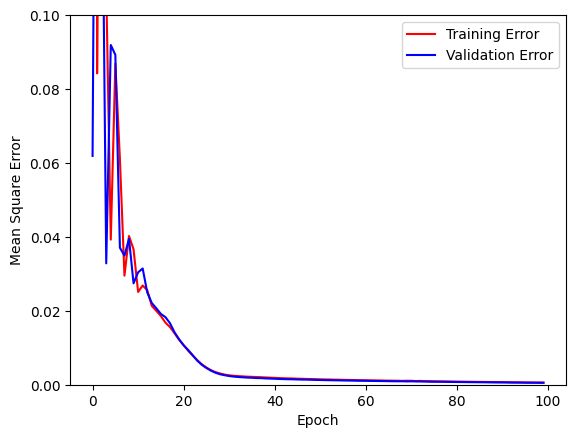

,loss,mean_squared_error,val_loss,val_mean_squared_error,epoch
0,0.976,0.976,0.062,0.062,0
1,0.084,0.084,0.263,0.263,1
2,0.281,0.281,0.157,0.157,2
3,0.107,0.107,0.033,0.033,3
4,0.039,0.039,0.092,0.092,4
...,...,...,...,...,...
95,0.001,0.001,0.001,0.001,95
96,0.001,0.001,0.001,0.001,96
97,0.001,0.001,0.001,0.001,97
98,0.001,0.001,0.001,0.001,98


In [397]:
model = my_model(learning_rate)
history, mse = train_model(model, normed_train_data, train_labels, epochs, batch_size)
plot_loss_curve(history)
display(history)

# Predicciones

4/4 [==============================] - 0s 1ms/step


,Iy,PF,e,dIf,If,Prediccion If
0,3.000,0.660,0.340,0.383,1.563,1.591
9,3.000,0.840,0.160,0.221,1.401,1.545
23,3.100,0.760,0.240,0.310,1.490,1.290
28,3.100,0.860,0.140,0.193,1.373,1.384
42,3.200,0.780,0.220,0.318,1.498,1.432
...,...,...,...,...,...,...
91,3.500,0.680,0.320,0.395,1.575,1.762
94,3.500,0.740,0.260,0.349,1.529,1.462
95,3.500,0.760,0.240,0.285,1.465,1.343
98,3.500,0.820,0.180,0.216,1.396,1.817


0      0.028
9     -0.022
23    -0.008
28    -0.017
42    -0.020
       ...  
531   -0.018
537    0.012
540    0.004
541   -0.023
550    0.034
Name: If, Length: 111, dtype: float64


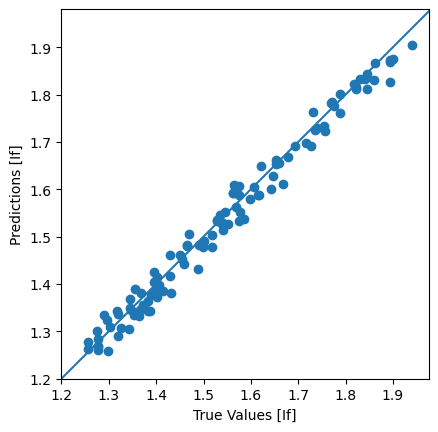

In [398]:
test_predictions = model.predict(normed_test_data).flatten()
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [If]')
plt.ylabel('Predictions [If]')
plt.axis('equal')
plt.axis('square')
plt.xlim([1.2,plt.xlim()[1]])
plt.ylim([1.2,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

test_predictions_df = pd.DataFrame(test_predictions, columns=['Prediccion If'])
test_predictions_df

results = pd.concat([test_df, test_labels, test_predictions_df], axis=1, join='inner')
display(results)

error = test_predictions - test_labels
print(error)
